<a href="https://www.kaggle.com/code/ocanaydin/fake-real-football-news-analysis?scriptVersionId=129929766" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [135]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-football/real.csv
/kaggle/input/fake-news-football/fake.csv


# DATA PREPROCESSING

**Get fake and real news,then concatenate them as one dataframe.**

In [136]:
df_fake = pd.read_csv("/kaggle/input/fake-news-football/fake.csv")
#Add 0 to each row to indicate it is a fake news.
zeros = pd.DataFrame(np.zeros(len(df_fake)),columns = ["label"])
df_fake = pd.concat([df_fake,zeros],axis = 1)

df_fake.head(5)

,tweet,label
0,"the tongue of his condition, now i saw things ...",0.0
1,"by god the great, after i saw the derby of wyd...",0.0
2,"believe in god, this zamalek fans are as good ...",0.0
3,the coach appeared in the media and told the t...,0.0
4,asno smito\nwhoever knows her tells me a massa...,0.0


In [137]:
df_real = pd.read_csv("/kaggle/input/fake-news-football/real.csv")
#Add 1 to each row to indicate it is a real news.
ones = pd.DataFrame(np.ones(len(df_real)),columns = ["label"])
df_real = pd.concat([df_real,ones],axis = 1)

df_real.head(5)

,tweet,label
0,sun downs technical director: al-ahly respecte...,1.0
1,shawky gharib after the tie with enppi: our go...,1.0
2,"egyptian sports news today, wednesday 1/25/202...",1.0
3,the main referees committee of the egyptian fo...,1.0
4,"haji bari, the striker of the future team, is ...",1.0


In [138]:
#Concatanate fake and real news dataframes.
df = pd.concat([df_real,df_fake],axis = 0)
#Shuffle dataset.
df = df.sample(frac = 1).reset_index(drop = True)

df.head(10)

,tweet,label
0,"praise be to god, i expect the top scorer in t...",0.0
1,"praise be to god, salvation is over. al-ahly b...",0.0
2,"haha, what is happening in this spanish league?",0.0
3,will queiroz return again to coach the egyptia...,1.0
4,a clarification: all the penalties announced b...,1.0
5,"_ abha, give him the league to solve it",0.0
6,"drumming for al-hilal, al-hilal took the leagu...",0.0
7,"today, the round of 16 matches of the egypt cu...",1.0
8,-hilal _ zamalek\nal-hilal plays with escobar ...,0.0
9,africa - piggy bank\nleague - fifth\nthe cup i...,0.0


**See frequencies of labels on histogram.**

<AxesSubplot: title={'center': 'Label'}, ylabel='Frequency'>

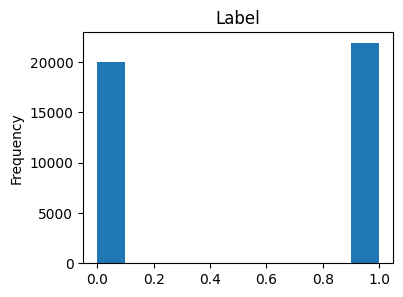

In [139]:
df["label"].plot(kind = "hist",title = "Label",figsize = (4,3))

**Check if any null value in dataset.**

In [140]:
print(df.isnull().sum())

#Remove null rows.
df.dropna(axis = 0,inplace = True)

print(df.isnull().sum())

tweet    17
label     0
dtype: int64
tweet    0
label    0
dtype: int64


In [141]:
df.head(10)

,tweet,label
0,"praise be to god, i expect the top scorer in t...",0.0
1,"praise be to god, salvation is over. al-ahly b...",0.0
2,"haha, what is happening in this spanish league?",0.0
3,will queiroz return again to coach the egyptia...,1.0
4,a clarification: all the penalties announced b...,1.0
5,"_ abha, give him the league to solve it",0.0
6,"drumming for al-hilal, al-hilal took the leagu...",0.0
7,"today, the round of 16 matches of the egypt cu...",1.0
8,-hilal _ zamalek\nal-hilal plays with escobar ...,0.0
9,africa - piggy bank\nleague - fifth\nthe cup i...,0.0


**Split dataset as train,test and validation.**

In [142]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df["tweet"],df["label"],test_size = 0.4,random_state = 42,
                                                shuffle = False)


In [143]:
#Create a validation dataset from test dataset.
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size = 0.5,random_state = 42,
                                            shuffle = False)

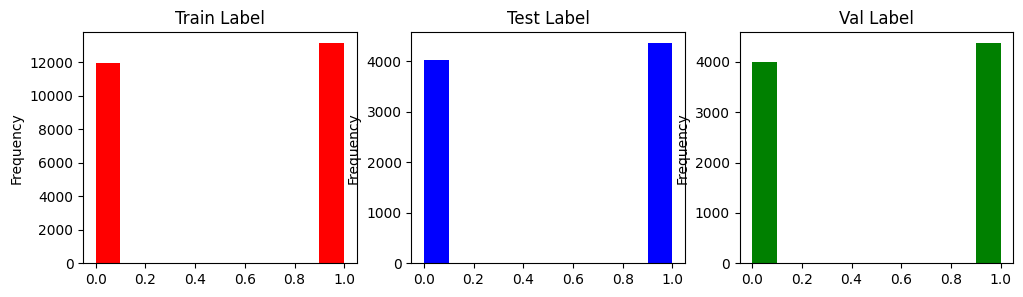

In [144]:
import matplotlib.pyplot as plt
#See the frequencies of labels on train,test and val.
plt.figure(figsize = (12,3))
plt.subplot(1,3,1)
pd.DataFrame(y_train,columns = ["label"])["label"].plot(kind = "hist",title = "Train Label",color = "r")
plt.subplot(1,3,2)
pd.DataFrame(y_test,columns = ["label"])["label"].plot(kind = "hist",title = "Test Label",color = "b")
plt.subplot(1,3,3)
pd.DataFrame(y_val,columns = ["label"])["label"].plot(kind = "hist",title = "Val Label",color = "g")
plt.show()

# TENSORFLOW HUB FOR NLP

In [145]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

In [ ]:
#Load tf model from hub and use its embedding.
embedding = hub.load(module_url)
embeddings = embedding(["This is a cat."])
print(embeddings)

# DEFINE MODEL AND COMPILE IT

In [147]:
def nlp_model(module_url,embed_size,trainable = False):
    #Define hub model with following parameters.
    hub_layer = hub.KerasLayer(module_url,input_shape = [],output_shape = [embed_size],
                              dtype = tf.string,trainable = trainable)
    model = tf.keras.Sequential()
    model.add(hub_layer)
    #two hidden layers.
    model.add(tf.keras.layers.Dense(256,activation = "relu"))
    model.add(tf.keras.layers.Dense(64,activation = "relu"))
    #output layer
    model.add(tf.keras.layers.Dense(1,activation = "sigmoid"))
    
    return model
    

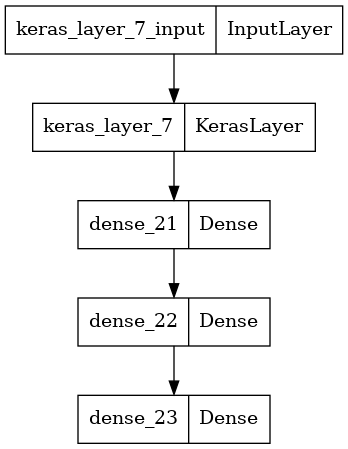

In [148]:
#Define model and see its diagram.
model = nlp_model(module_url,512,False)
tf.keras.utils.plot_model(model)

In [149]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 64)                16448     
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,945,665
Trainable params: 147,841
Non-trainable params: 256,797,824
_________________________________________________________________


In [150]:
#Compile model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics =[tf.metrics.BinaryAccuracy(name = "Accuracy")])

# TRAIN MODEL

In [151]:
history = model.fit(x = X_train,y = y_train,validation_data = (X_val,y_val),epochs = 50,
                        batch_size = 64,callbacks = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                        patience = 3,mode = "min"))

Epoch 1/50
393/393 [==============================] - 12s 22ms/step - loss: 0.4022 - Accuracy: 0.8387 - val_loss: 0.2391 - val_Accuracy: 0.9030
Epoch 2/50
393/393 [==============================] - 9s 23ms/step - loss: 0.2184 - Accuracy: 0.9130 - val_loss: 0.2142 - val_Accuracy: 0.9139
Epoch 3/50
393/393 [==============================] - 8s 21ms/step - loss: 0.2030 - Accuracy: 0.9197 - val_loss: 0.2054 - val_Accuracy: 0.9179
Epoch 4/50
393/393 [==============================] - 9s 22ms/step - loss: 0.1957 - Accuracy: 0.9218 - val_loss: 0.2011 - val_Accuracy: 0.9192
Epoch 5/50
393/393 [==============================] - 8s 21ms/step - loss: 0.1906 - Accuracy: 0.9245 - val_loss: 0.1985 - val_Accuracy: 0.9209
Epoch 6/50
393/393 [==============================] - 10s 25ms/step - loss: 0.1854 - Accuracy: 0.9264 - val_loss: 0.1947 - val_Accuracy: 0.9218
Epoch 7/50
393/393 [==============================] - 8s 21ms/step - loss: 0.1804 - Accuracy: 0.9290 - val_loss: 0.1912 - val_Accuracy: 0.92

# EVALUATE MODEL AND PLOT HISTORY.

In [152]:
loss,acc = model.evaluate(X_test,y_test)
print(f"loss : {loss} , accuracy : {acc}")

262/262 [==============================] - 3s 12ms/step - loss: 0.1715 - Accuracy: 0.9325
loss : 0.17149251699447632 , accuracy : 0.9324970245361328


In [153]:
history = history.history

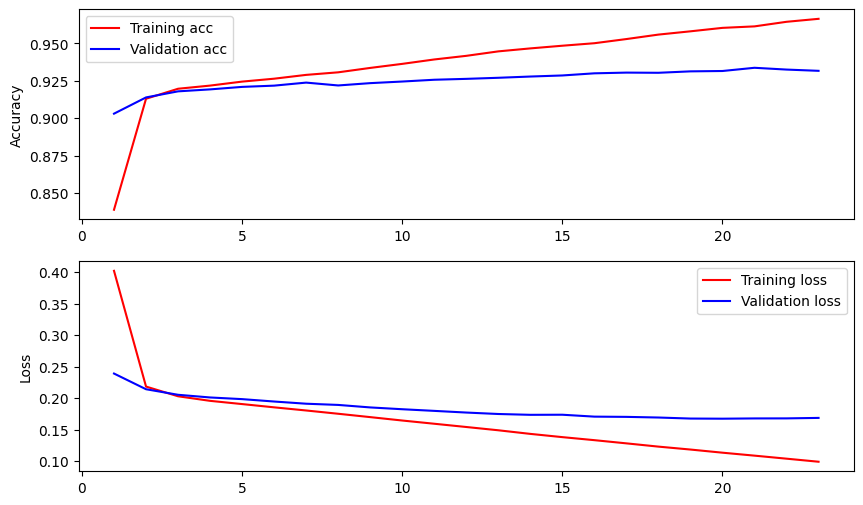

In [154]:
import matplotlib.pyplot as plt
#Metrics
acc = history["Accuracy"]
loss = history["loss"]
val_acc = history["val_Accuracy"]
val_loss = history["val_loss"]

epochs = range(1,len(acc) + 1)

#Plot Accuracy
fig = plt.figure(figsize = (10,6))
plt.subplot(2,1,1)
plt.plot(epochs,acc,"r",label = "Training acc")
plt.plot(epochs,val_acc,"b",label = "Validation acc")
plt.ylabel("Accuracy")
plt.legend()

#Plot Loss
plt.subplot(2,1,2)
plt.plot(epochs,loss,"r",label = "Training loss")
plt.plot(epochs,val_loss,"b",label = "Validation loss")
plt.ylabel("Loss")
plt.legend()

plt.show()

# SAVE MODEL

In [155]:
model.save("fake_real_football_news_analysis")

# PREDICTION

In [157]:
#pred decoder
def preds_decoder(preds):
    decoded_preds = []
    for i in range(len(preds)):
        if preds[i] >= 0.5 :
            decoded_preds.append(1.0)
        else:
            decoded_preds.append(0.0)
    return decoded_preds

In [162]:
#(2)Predict label.
preds = model.predict(X_test)
#(3)Use above function to classify sigmoid output as 1 or 0.
final_preds = preds_decoder(preds)

262/262 [==============================] - 4s 14ms/step


In [164]:
#Our final preds.
print(final_preds[0:10])

[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]


In [166]:
#Compare preds and real values.
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,final_preds)
print(cm)
cr = classification_report(y_test,final_preds)
print(cr)

[[3772  248]
 [ 317 4033]]
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      4020
         1.0       0.94      0.93      0.93      4350

    accuracy                           0.93      8370
   macro avg       0.93      0.93      0.93      8370
weighted avg       0.93      0.93      0.93      8370



In [169]:
#Create dataframe which shows the predicts.
df_preds = pd.DataFrame(final_preds,columns = ["preds"],index = X_test.index)
#Concatenate x_test,y_test and df_preds.
df_final = pd.concat([X_test,y_test,df_preds],axis = 1)

In [170]:
df_final

,tweet,label,preds
25125,"d.22, and hamoudi penetrated from the yemen fr...",1.0,0.0
25126,"mortada has been walking for five months, and ...",0.0,0.0
25127,hahahaha\nthe guard is a joke,0.0,0.0
25128,"hossam hassan was born on august 10, 1966 in h...",1.0,1.0
25129,"the egyptian international referee team, alaa ...",1.0,1.0
...,...,...,...
33492,_ eternity\nthe royal begins the journey to r...,0.0,0.0
33493,"in the absence of the role of parliament, its ...",0.0,0.0
33494,khaled al-ghannam takes the ball from angels a...,0.0,0.0
33495,the matches between zamalek and al-nasr al-sau...,1.0,1.0
